In [1]:
# Loading libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading online retailer data
file_path = "C://Users//lenovo//Desktop//7LYTIX//online_retail_II.csv"
onlineRetailer_df = pd.read_csv(file_path, encoding= 'ISO-8859-1')
# Preview the original data
onlineRetailer_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


In [3]:
# Check for missing values
onlineRetailer_df.isnull().sum()

Invoice             0
StockCode           0
Description      4372
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236682
Country             0
dtype: int64

In [4]:
# Remove missing values
onlineRetailer_df.dropna(inplace=True)

In [5]:
#create dataframe for InvoiceDate
onlineRetailer_df['InvoiceDate'] = pd.to_datetime(onlineRetailer_df['InvoiceDate'])

In [6]:
# For training the model, we will take into consideration the last 9 months in the data set
# so that, we will take 9 monthes of behavioral data between January 2011 and August 2011,
# and for the next purchase date, we will take 3 monthes (between September 2011 and October 2011)
first_period = onlineRetailer_df[(onlineRetailer_df.InvoiceDate >= datetime(2011,1,1)) & (onlineRetailer_df.InvoiceDate < datetime(2011,9,1))].reset_index(drop=True)
next_period = onlineRetailer_df[(onlineRetailer_df.InvoiceDate >= datetime(2011,9,1)) & (onlineRetailer_df.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)

In [7]:
# Create dataframe for customer ides
customers = pd.DataFrame(first_period['Customer ID'].unique())
customers.columns = ['Customer ID']

In [8]:
# Create the feature 'NextPurchaseDay' which represents the next purchase day between
# the first period (9 monthes) and the second period (next 3 monthes)
# in odrder to include it in the customer feature vectors

# Create a dataframe with customer id and first purchase date in next_period
next_period_first_purchase = next_period.groupby('Customer ID').InvoiceDate.min().reset_index()
next_period_first_purchase.columns = ['Customer ID','MinPurchaseDate']

# Create a dataframe with customer id and last purchase date in first_period
last_purchase = first_period.groupby('Customer ID').InvoiceDate.max().reset_index()
last_purchase.columns = ['Customer ID','MaxPurchaseDate']

# Merge two dataframes
purchase_dates = pd.merge(last_purchase,next_period_first_purchase,on='Customer ID',how='left')

# Calculate the time difference in days:
purchase_dates['NextPurchaseDay'] = (purchase_dates['MinPurchaseDate'] - purchase_dates['MaxPurchaseDate']).dt.days

# Merge with customers 
customers = pd.merge(customers, purchase_dates[['Customer ID','NextPurchaseDay']],on='Customer ID',how='left')

# Fill NA values with -1
customers = customers.fillna(-1)

In [9]:
# Create the feature 'Recency' which represents the number of days that have passed 
# since the customer last purchased (in the first period)
# in odrder to include it in the customer feature vectors

# Get max purchase date for Recency and create a dataframe
max_purchase = first_period.groupby('Customer ID').InvoiceDate.max().reset_index()
max_purchase.columns = ['Customer ID','MaxPurchaseDate']

# Calculate the recency in days
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
# Add 'recency' feature to customers
customers = pd.merge(customers, max_purchase[['Customer ID','Recency']], on='Customer ID')

In [10]:
# Create the feature 'Frequency' which represents the number of purchases by the customer (in the first period)
# in odrder to include it in the customer feature vectors

# Get total count of purchases
frequency = first_period.groupby('Customer ID').InvoiceDate.count().reset_index()
frequency.columns = ['Customer ID','Frequency']

# Add 'Frequency' feature to customers
customers = pd.merge(customers, frequency, on='Customer ID')

In [11]:
# Create the feature 'Revenue' where Revenue = quantity*price (in the first period)
# in odrder to include it in the customer feature vectors

first_period['Revenue'] = first_period['Price'] * first_period['Quantity']
revenue = first_period.groupby('Customer ID').Revenue.sum().reset_index()

# Add 'Revenue' feature to customers
customers = pd.merge(customers, revenue, on='Customer ID')

In [12]:
# Preview the data..
customers.head()

,Customer ID,NextPurchaseDay,Recency,Frequency,Revenue
0,13313.0,105.0,40,47,918.34
1,18097.0,-1.0,0,78,1823.93
2,16656.0,20.0,16,52,5782.93
3,16875.0,73.0,40,67,1078.95
4,13094.0,49.0,29,23,1103.58


In [13]:
# Now, we will create new three features depedning on the shift() method (shift features), 
# to find out the time delay between the last three purchases

# Create a dataframe with CustomerID and Invoice Date
day_order = first_period[['Customer ID','InvoiceDate']]
day_order['InvoiceDate'] = day_order['InvoiceDate'].dt.date
# Sort the values
day_order = day_order.sort_values(['Customer ID','InvoiceDate'])
# Drop duplicates
day_order = day_order.drop_duplicates(subset=['Customer ID','InvoiceDate'],keep='first')

In [14]:
#shift last 3 purchase dates
day_order['PrevInvoiceDate'] = day_order.groupby('Customer ID')['InvoiceDate'].shift(1)
day_order['T2InvoiceDate'] = day_order.groupby('Customer ID')['InvoiceDate'].shift(2)
day_order['T3InvoiceDate'] = day_order.groupby('Customer ID')['InvoiceDate'].shift(3)

In [15]:
# Calculate the delay between the sequential shifts
day_order['DayDiff'] = (day_order['InvoiceDate'] - day_order['PrevInvoiceDate']).dt.days
day_order['DayDiff2'] = (day_order['InvoiceDate'] - day_order['T2InvoiceDate']).dt.days
day_order['DayDiff3'] = (day_order['InvoiceDate'] - day_order['T3InvoiceDate']).dt.days

In [16]:
# Preview the 'shift features'
day_order.head()

,Customer ID,InvoiceDate,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
11270,12346.0,2011-01-18,NaN,NaN,NaN,NaN,NaN,NaN
17774,12347.0,2011-01-26,NaN,NaN,NaN,NaN,NaN,NaN
75161,12347.0,2011-04-07,2011-01-26,NaN,NaN,71.0,NaN,NaN
130869,12347.0,2011-06-09,2011-04-07,2011-01-26,NaN,63.0,134.0,NaN
178544,12347.0,2011-08-02,2011-06-09,2011-04-07,2011-01-26,54.0,117.0,188.0


In [17]:
# Calculate the mean and the standard deviation of the 'shift features' aggregated by customer
day_diff = day_order.groupby('Customer ID').agg({'DayDiff': ['mean','std']}).reset_index()
day_diff.columns = ['Customer ID', 'DayDiffMean','DayDiffStd']

In [18]:
# Drop duplicates and keep the last values
day_order_last = day_order.drop_duplicates(subset=['Customer ID'],keep='last')

In [19]:
day_order_last = day_order_last.dropna()
day_order_last = pd.merge(day_order_last, day_diff, on='Customer ID')

# Mergee shift feautes with the pervious feautres
customers = pd.merge(customers, day_order_last[['Customer ID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='Customer ID')

In [20]:
# Preview the last version of customers included the final feature vectors
customers.head()

,Customer ID,NextPurchaseDay,Recency,Frequency,Revenue,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,18097.0,-1.0,0,78,1823.93,26.0,105.0,239.0,79.666667,54.003086
1,16656.0,20.0,16,52,5782.93,4.0,6.0,27.0,18.583333,15.258132
2,16875.0,73.0,40,67,1078.95,3.0,100.0,155.0,39.600000,38.559046
3,13094.0,49.0,29,23,1103.58,27.0,53.0,57.0,19.090909,19.294842
4,17315.0,13.0,0,354,4229.72,8.0,15.0,27.0,9.560000,6.551590


In [21]:
# Create customers_class as a copy of customers before applying get_dummies
# Kindly note the the dataframe customers_class contains the label attribute depending on the NextPurchaseDay feature as follows:
# if NextPurchaseDay <= 20 --> class values = 2
# if NextPurchaseDay between 20 and 50 --> class values = 1
# if NextPurchaseDay > 50 --> class values = 0
customers_class = customers.copy()
customers_class = pd.get_dummies(customers_class)

In [22]:
customers_class['NextPurchaseDayRange'] = 2
customers_class.loc[customers.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
customers_class.loc[customers.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

In [23]:
# Preview the customers_class
customers_class.head()

,Customer ID,NextPurchaseDay,Recency,Frequency,Revenue,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,NextPurchaseDayRange
0,18097.0,-1.0,0,78,1823.93,26.0,105.0,239.0,79.666667,54.003086,2
1,16656.0,20.0,16,52,5782.93,4.0,6.0,27.0,18.583333,15.258132,2
2,16875.0,73.0,40,67,1078.95,3.0,100.0,155.0,39.600000,38.559046,0
3,13094.0,49.0,29,23,1103.58,27.0,53.0,57.0,19.090909,19.294842,1
4,17315.0,13.0,0,354,4229.72,8.0,15.0,27.0,9.560000,6.551590,2


In [24]:
feature_cols = ['Recency','Frequency','Revenue','DayDiffMean','DayDiffStd']
X = customers_class[feature_cols] # Features
y = customers_class.NextPurchaseDayRange # Target variable

In [25]:
#train & test split
# customers_class = customers_class.drop('NextPurchaseDay',axis=1)
# X, y = customers_class.drop('NextPurchaseDayRange',axis=1), customers_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [26]:
# Measure the model accuracy 
kfold = KFold(n_splits=2, random_state=22)
acc = cross_val_score(clf,X_train,y_train, cv = kfold,scoring = "accuracy")
print("Accuracy:",acc)

Accuracy: [0.55016181 0.52750809]


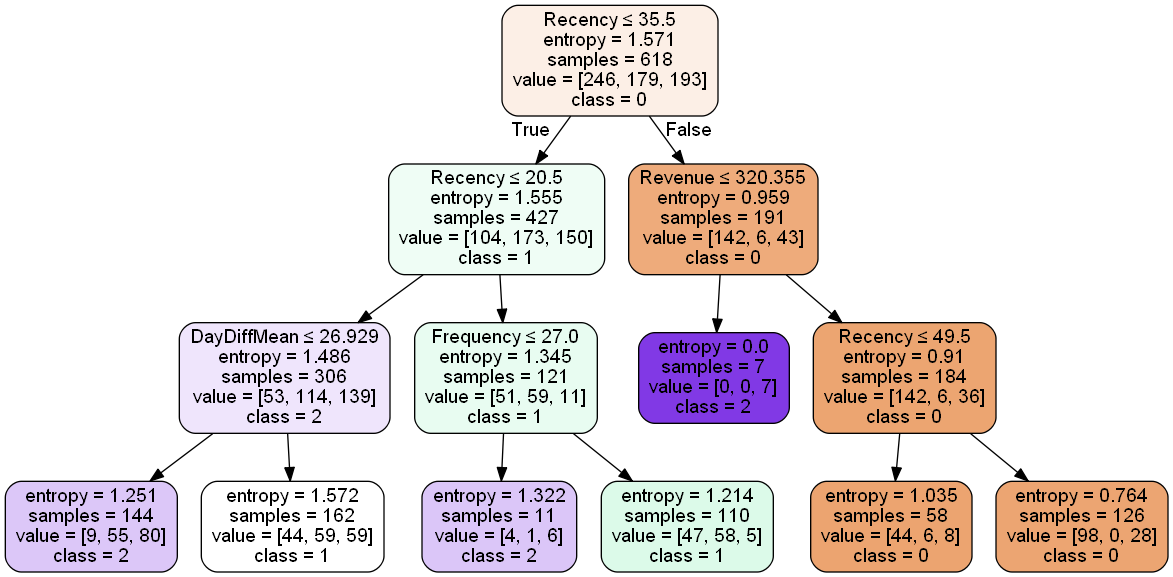

In [27]:
# Preview the Decision Tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())